In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
pd.options.display.max_columns = 999
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score as cvs
from sklearn.metrics import confusion_matrix,precision_recall_curve,roc_curve
from sklearn.metrics import mean_absolute_error, recall_score, precision_score, roc_auc_score, average_precision_score,f1_score
import lightgbm as lgb
import catboost as cat
import xgboost as xgb
import re
pd.options.display.max_columns = 999

import warnings # Для игнора предупреждений
warnings.filterwarnings("ignore")

#### Функция для построения confusion matrix

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Загружаем очищенные данные

In [104]:
data19=pd.read_csv('df2019_model.csv',index_col=0)
data20=pd.read_csv('df2020_model.csv',index_col=0)

data19.head(1)

,"1, cf_likv1","1, cf_likv2","1, cf_likv3","1, cf_ob1","1, cf_ob2","1, cf_ob3","1, cf_ob4","1, cf_ob5","1, cf_rent1","1, cf_rent2","1, cf_rent3","1, сf_rent4","1, сf_rent5","1, сf_rent6","1, cf_rent7","1, cf_ru1","1, cf_ru2","1, cf_ru3","1, cf_ru4","1, cf_ru5","1, cf_ru6","1, cf_ru7","1, cf_ru8","1, cf_fu1","1, cf_fu2","1, cf_fu3","1, cf_fu4","1, cf_fu5","1, cf_fu6","2, cf_likv1","2, cf_likv2","2, cf_likv3","2, cf_ob1","2, cf_ob2","2, cf_ob3","2, cf_ob4","2, cf_ob5","2, cf_rent1","2, cf_rent2","2, cf_rent3","2, сf_rent4","2, сf_rent5","2, сf_rent6","2, cf_rent7","2, cf_ru1","2, cf_ru2","2, cf_ru3","2, cf_ru4","2, cf_ru5","2, cf_ru6","2, cf_ru7","2, cf_ru8","2, cf_fu1","2, cf_fu2","2, cf_fu3","2, cf_fu4","2, cf_fu5","2, cf_fu6","3, cf_likv1","3, cf_likv2","3, cf_likv3","3, cf_ob1","3, cf_ob2","3, cf_ob3","3, cf_ob4","3, cf_ob5","3, cf_rent1","3, cf_rent2","3, cf_rent3","3, сf_rent4","3, сf_rent5","3, сf_rent6","3, cf_rent7","3, cf_ru1","3, cf_ru2","3, cf_ru3","3, cf_ru4","3, cf_ru5","3, cf_ru6","3, cf_ru7","3, cf_ru8","3, cf_fu1","3, cf_fu2","3, cf_fu3","3, cf_fu4","3, cf_fu5","3, cf_fu6","1-2, cf_likv1","2-3, cf_likv1","1-2, cf_likv2","2-3, cf_likv2","1-2, cf_likv3","2-3, cf_likv3","1-2, cf_ob1","2-3, cf_ob1","1-2, cf_ob2","2-3, cf_ob2","1-2, cf_ob3","2-3, cf_ob3","1-2, cf_ob4","2-3, cf_ob4","1-2, cf_ob5","2-3, cf_ob5","1-2, cf_rent1","2-3, cf_rent1","1-2, cf_rent2","2-3, cf_rent2","1-2, cf_rent3","2-3, cf_rent3","1-2, сf_rent4","2-3, сf_rent4","1-2, сf_rent5","2-3, сf_rent5","1-2, сf_rent6","2-3, сf_rent6","1-2, cf_rent7","2-3, cf_rent7","1-2, cf_ru1","2-3, cf_ru1","1-2, cf_ru2","2-3, cf_ru2","1-2, cf_ru3","2-3, cf_ru3","1-2, cf_ru4","2-3, cf_ru4","1-2, cf_ru5","2-3, cf_ru5","1-2, cf_ru6","2-3, cf_ru6","1-2, cf_ru7","2-3, cf_ru7","1-2, cf_ru8","2-3, cf_ru8","1-2, cf_fu1","2-3, cf_fu1","1-2, cf_fu2","2-3, cf_fu2","1-2, cf_fu3","2-3, cf_fu3","1-2, cf_fu4","2-3, cf_fu4","1-2, cf_fu5","2-3, cf_fu5","1-2, cf_fu6","2-3, cf_fu6",ПДЗ,target
0,1.020214,0.975787,0.531527,6.094585,10.657441,6.762855,16.179594,0.713523,0.023532,0.021702,0.087606,0.325947,0.347832,1.901627,0.122779,0.052601,2.720623,0.019814,5.834154,0.634566,0.956453,0.111153,0.105925,0.268772,0.268772,0.171404,0.046069,-0.024814,0.019814,1.296635,1.226782,0.655178,7.058611,11.301351,9.348229,14.011003,0.75819,0.148945,0.184913,0.792946,2.075945,3.419407,100.0,1.045841,0.454103,1.618015,0.228773,100.0,0.827178,0.946127,0.13769,0.080178,0.381969,0.381969,0.0,0.0,0.184859,0.228773,1.238697,1.16859,0.625742,5.170578,7.443841,6.538386,9.980091,0.727897,0.122966,0.147426,0.448599,1.189552,1.682625,100.0,0.616294,0.371943,1.651707,0.1927,100.0,0.878362,0.943403,0.129559,0.08549,0.377116,0.377116,0.0,0.0,0.144268,0.1927,0.276421,-0.057938,0.250995,-0.058192,0.123651,-0.029437,0.964026,-1.888032,0.64391,-3.857511,2.585374,-2.809843,-2.168591,-4.030912,0.044667,-0.030293,0.125413,-0.025979,0.163211,-0.037487,0.70534,-0.344347,1.749997,-0.886392,3.071575,-1.736782,100.0,0.0,0.923062,-0.429547,0.401503,-0.08216,-1.102608,0.033692,0.208959,-0.036073,100.0,0.0,0.192611,0.051184,-0.010326,-0.002724,0.026537,-0.008131,-0.025748,0.005312,0.113197,-0.004853,0.113197,-0.004853,-0.171404,0.0,-0.046069,0.0,0.209673,-0.040591,0.208959,-0.036073,0,0


#### Выделяем признаки и таргет

In [105]:
X=data19[[x for x in data19.columns if 'Наименование ДП' not in x and 'ПДЗ' not in x and 'target' not in x]]
y=data19['target']

#### Переименуем все фичи (чисто для LightGBM)

In [106]:
for i in range(len(X.columns)):
    X=X.rename({X.columns[i]: X.columns[i].replace(',','_')},axis=1)

#### Считаем распределение уровней таргета

In [107]:
for k in set(y):
    print(f'Доля класса {k}: {round(len(y[y==k])/len(y)*100,2)}%')

Доля класса 0: 41.62%
Доля класса 1: 45.96%
Доля класса 2: 6.71%
Доля класса 3: 1.58%
Доля класса 4: 4.14%


### Модель будем строить по данным 2019 года

**Гиперпараметры подбираем вручную на кросс-валидации**

In [150]:
%%time
params={
             'min_data_in_leaf':40,       
             'learning_rate' : 0.001,
             'max_depth': 2,
             'objective': 'lambdarank',
             'n_estimators': 1000,
             'boosting_type': 'goss',
             'random_state': 5 # 5 - 0.5042
}

model=lgb.LGBMClassifier(**params).fit(X,y)
                                      
f1_list=cvs(model,X,y,scoring='f1_weighted')          
roc_auc_list=cvs(model,X,y,scoring='roc_auc_ovr') 
print('--------------------------------------------------------------------')
print(f1_list)
print(f'Средний F1: {round(np.mean(f1_list),3)}')
print('--------------------------------------------------------------------')
print(roc_auc_list)
print(f'Средний ROC AUC: {round(np.mean(roc_auc_list),3)}')

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min

#### Смотрим важность признаков

In [151]:
fig = px.bar(
        x=X.columns, y=model.feature_importances_,
        labels=dict(x='Feature', y='Feature Importances'),
        title='Weight of each feature'
)

fig.show()

### Оцениваем качество на данных 2020 года - независимой выборке

#### Выделяем признаки и таргет

In [152]:
X_2020=data20[[x for x in data20.columns if 'Наименование ДП' not in x and 'ПДЗ' not in x and 'target' not in x]]
y_2020=data20['target']

#### Переименуем все фичи

In [153]:
for i in range(len(X_2020.columns)):
    X_2020=X_2020.rename({X_2020.columns[i]: X_2020.columns[i].replace(',','_')},axis=1)

#### Считаем распределение уровней таргета

In [154]:
for k in set(y_2020):
    print(f'Доля класса {k}: {round(len(y_2020[y_2020==k])/len(y_2020)*100,2)}%')

Доля класса 0: 31.3%
Доля класса 1: 53.05%
Доля класса 2: 7.63%
Доля класса 3: 1.91%
Доля класса 4: 6.11%


#### Строим прогноз

In [155]:
y_pred=model.predict(X_2020)
y_prob=model.predict_proba(X_2020)

#### Смотрим качество

In [156]:
print(f'Взвешенный F1: {round(f1_score(y_2020,y_pred,average="weighted"),3)}')
print(f'ROC AUC OVR: {round(roc_auc_score(y_2020,y_prob,multi_class="ovr"),3)}')

Взвешенный F1: 0.43
ROC AUC OVR: 0.585


#### Смотрим качество в разрезе каждого класса

In [157]:
st = {
      'F1': f1_score(y_2020,y_pred,average=None),
      'Precision': precision_score(y_2020,y_pred,average=None),
      'Recall': recall_score(y_2020,y_pred,average=None)
       }

table=pd.DataFrame(st).T
table.columns=['ПДЗ=0', '1<=ПДЗ<=30','31<=ПДЗ<=60','61<=ПДЗ<=90','ПДЗ>90']
display(round(table,4))

,ПДЗ=0,1<=ПДЗ<=30,31<=ПДЗ<=60,61<=ПДЗ<=90,ПДЗ>90
F1,0.3626,0.5962,0.0,0.0,0.0
Precision,0.3483,0.5376,0.0,0.0,0.0
Recall,0.3780,0.6691,0.0,0.0,0.0


#### Смотрим confusion matrix

Confusion matrix, without normalization


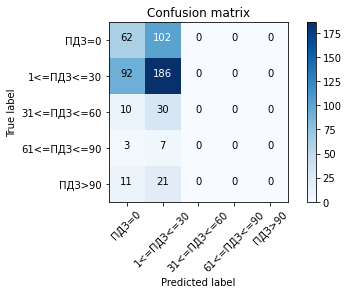

In [158]:
cm = confusion_matrix(y_2020, y_pred)
plot_confusion_matrix(cm, classes=['ПДЗ=0', '1<=ПДЗ<=30','31<=ПДЗ<=60','61<=ПДЗ<=90','ПДЗ>90'])